In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import gsw

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vozocrtx0 = dsU.variables['vozocrtx'][time_s:time_f,:,y,x]
        vomecrty0 = dsV.variables['vomecrty'][time_s:time_f,:,y,x]
        vovecrtz0 = dsW.variables['vovecrtz'][time_s:time_f,:,y,x]
        vosaline0 = dsT.variables['vosaline'][time_s:time_f, :, y, x]
        votemper0 = dsT.variables['votemper'][time_s:time_f, :, y, x]
        sossheig0 = dsT.variables['sossheig'][time_s:time_f, y, x]
        sozotaux = dsU.variables['sozotaux'][time_s:time_f,0,0]
        depthu = dsU.variables['depthu'][:]
        deptht = dsT.variables['deptht'][:]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]
        vmask0 = dsM.variables['vmask'][0,:,y,x]
        tmask0 = dsM.variables['tmask'][0,:,y,x]
        tmask_ss0 = dsM.variables['tmask'][0, 0, y, x]
        e3t = dsM.variables['e3t_0'][0, :, 0, 0]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1)) 
    tmask_ss = np.tile(tmask_ss0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    votemper = np.ma.array(votemper0, mask=1 - tmask)
    sossheig = np.ma.array(sossheig0, mask=1 - tmask_ss)
    
    return vozocrtx, vomecrty, vovecrtz, vosaline, votemper, sossheig, umask, vmask, tmask, depthu, deptht, e3t, sozotaux

In [3]:
def get_salt_daily(time_s):
    time_f = time_s+24
    vozocrtx, vomecrty, vovecrtz, vosaline, votemper, sossheig, umask, vmask, tmask, depthu, deptht, e3t, sozotaux = get_vels(dirname, fname, meshmaskname, time_s, time_f)
    vosaline_daily = np.mean(vosaline, axis=0)
    votemper_daily = np.mean(votemper, axis=0)
    sossheig_daily = np.mean(sossheig, axis=0)
    vozocrtx_daily = np.mean(vozocrtx, axis=0)
    vomecrty_daily = np.mean(vomecrty, axis=0)
    vovecrtz_daily = np.mean(vovecrtz, axis=0)
    return vosaline_daily, votemper_daily, sossheig_daily, vozocrtx_daily, vomecrty_daily, vovecrtz_daily, depthu, deptht, e3t

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [4]:
def calculate_pressure(vosaline, votemper, sossheig, e3t):
    ''' returns pressure in decibars
    '''
    g = 9.81

    rho = np.full([vosaline.shape[-3], vosaline.shape[-2], vosaline.shape[-1]], np.nan)
    p_stat0 = np.full_like(rho, np.nan)
    p_stat = np.full_like(rho, np.nan)
    p_surf = np.full([vosaline.shape[-2], vosaline.shape[-1]], np.nan)
    pressure = np.full_like(rho, np.nan)
        
    for k in range(vosaline.shape[-3]):
        gsw_vosaline = vosaline[k, :, :]
        gsw_votemper = votemper[k, :, :]
        rho[k, :, :] = gsw.rho(gsw_vosaline, gsw_votemper, 0)
        p_stat0[k, :, :] = rho[k, :, :] * e3t[k]

    for k in range(1, len(e3t)+1): 
        p_stat[k-1, :, :] = g * np.sum(p_stat0[:k, :, :], axis=0)

    p_surf[:, :] = rho[0, :, :] * g * sossheig[:, :]

    for k in range(vosaline.shape[-3]):
        pressure[:, :] = p_stat[:, :] + p_surf[:, :]
            
    pressure_db = pressure * 0.0001
        
    return pressure_db

In [5]:
def plot(vosaline_daily_all, votemper_daily_all, sossheig_daily_all,
         vozocrtx_daily_all, vomecrty_daily_all, vovecrtz_daily, salt, ttls, vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3):

    fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, gridspec_kw={'width_ratios': [5, 5, 5, 0.2, 0.1]}, 
                             figsize=(20, 22))

    for col in range(3):
        vosaline_daily = vosaline_daily_all[col]
        votemper_daily = votemper_daily_all[col]
        sossheig_daily = sossheig_daily_all[col]
        vozocrtx = vozocrtx_daily_all[col]
        vomecrty = vomecrty_daily_all[col]
        vovecrtz = vovecrtz_daily_all[col]
        
        for row in range(4):
            ax=axes[row, col]

            # Initial depth
            depth_initial = get_varb_surf(vosaline_ref_profile, salt, deptht)
            print(ttls[col], row, np.round(depth_initial, 2))
            
            # Particular day
                
            if row == 0:
                cmap = cmo.cm.matter
                cmap.set_bad('silver')
                ticks = tk0
                arrow=1
                arr = 9
                u_daily = get_varb_surf(vosaline_daily, salt, vozocrtx)
                v_daily = get_varb_surf(vosaline_daily, salt, vomecrty)
                x_slice, y_slice, u_nstg, v_nstg, speeds = quicklook.get_speeds(u_daily, v_daily, arrow)
                p = ax.pcolormesh(x_slice, y_slice, speeds, cmap=cmap, vmin=vm0[0], vmax=vm0[1])
                ax.quiver(x_slice[::arr], y_slice[::arr], u_nstg[::arr, ::arr], v_nstg[::arr, ::arr],
                          color='k', pivot='mid', clim=[vm0[0], vm0[1]], 
                          width=0.0045, headwidth=2.5, minlength=1.2)
                bathy_plot = bathy[1:, 1:]
                cbar_lab = 'Speeds [ms$^{-1}$]'
                print(np.round(np.nanmin(speeds),2), np.round(np.nanmax(speeds),2))
                
                where_min = np.where(speeds == np.nanmin(speeds))
                where_max = np.where(speeds == np.nanmax(speeds))
                for n in range(len(where_max[0])):
                    ax.scatter(where_max[1], where_max[0], c='#284CED', edgecolors='w', marker='D', s=100, alpha=0.9)
                    
            elif row == 1:
                cmap = cmo.cm.balance
                cmap.set_bad('silver')
                ticks = tk1
                w_daily0 = get_varb_surf(vosaline_daily, salt, vovecrtz)
                w_daily = w_daily0 * 1000
                #w_daily = w_daily00[:200, 170:]
                x_slice = np.arange(w_daily.shape[1])
                y_slice = np.arange(w_daily.shape[0])
                p = ax.pcolormesh(x_slice, y_slice, w_daily, cmap=cmap, vmin=vm1*-1, vmax=vm1)
                bathy_plot = bathy
                cbar_lab = 'Vertical Velocity [mms$^{-1}$]'
                print(np.round(np.nanmin(w_daily),2), np.round(np.nanmax(w_daily),2))
                #print(np.nanmean(np.where(w_daily>=0, w_daily ,np.nan)),
                #      np.nanmean(np.where(w_daily<=0, w_daily ,np.nan)))
                
            elif row == 2:
                cmap = cmo.cm.dense
                cmap.set_bad('silver')
                ticks = tk2
                levels = [25, 50, 75, 100, 115, 125, 375, 425, 450, 465, 475]
                pressure_db = calculate_pressure(vosaline_daily, votemper_daily, sossheig_daily, e3t)
                pressure_daily = get_varb_surf(vosaline_daily, salt, pressure_db)
                x_slice = np.arange(pressure_daily.shape[1])
                y_slice = np.arange(pressure_daily.shape[0])
                p = ax.pcolormesh(x_slice, y_slice, pressure_daily, cmap=cmap, vmin=vm2[0], vmax=vm2[1])
                cs = ax.contour(x_slice, y_slice, pressure_daily, levels=levels, colors='w', alpha=0.7, linewidths=0.5)
                ax.clabel(cs, inline=1, fontsize=17, fmt ='%1.f', colors='w')
                bathy_plot = bathy  
                cbar_lab = 'Pressure [dbar]'
                print(np.round(np.nanmin(pressure_daily),2), np.round(np.nanmax(pressure_daily),2))
                
            elif row == 3:
                norm = upwelling_functions.MidpointNormalize(midpoint=0)
                cmap = cmo.cm.delta_r
                cmap.set_bad('silver')
                ticks = tk3
                levels = [-5, 10, 20, 40, 60, 80]
                depth_daily = get_varb_surf(vosaline_daily, salt, deptht)
                disp_daily = depth_initial - depth_daily
                x_slice = np.arange(disp_daily.shape[1])
                y_slice = np.arange(disp_daily.shape[0])
                p = ax.pcolormesh(x_slice, y_slice, disp_daily, cmap=cmap, norm=norm, vmin=vm3[0], vmax=vm3[1])
                cs = ax.contour(x_slice, y_slice, disp_daily, levels=levels, colors='k', alpha=0.7, linewidths=0.5)
                ax.clabel(cs, inline=1, fontsize=17, fmt ='%1.f', colors='k')
                bathy_plot = bathy  
                cbar_lab = 'Vertical Displacement [m]'
                print(np.round(np.nanmin(disp_daily),2), np.round(np.nanmax(disp_daily),2))
                
                where_min = np.where(disp_daily == np.nanmin(disp_daily))
                where_max = np.where(disp_daily == np.nanmax(disp_daily))
                for n in range(len(where_max[0])):
                    ax.scatter(where_max[1], where_max[0], c='orangered', edgecolors='w', marker='D', s=100, alpha=0.9)
                
            ax.set_xlim([0, x_slice[-1]])
            ax.set_ylim([0, y_slice[-1]])
            ax.tick_params(axis='both', which='both', length=0, labelsize=15)
            ax.set_aspect(aspect='equal')

            if row==0: ax.set_title(ttls[col], fontsize=25, y=1.08)
            else: pass

            if row==3: ax.set_xlabel('x-indices', fontsize=20)
            else:pass

            if col==0:
                ax.set_ylabel('y-indices', fontsize=20)

            if col==2:
                axes[row, 3].axis('off')
                axc = axes[row, 4] 
                axc.axis('off')
                cbar = fig.colorbar(p, ax=axc, orientation='vertical', fraction=5.0, aspect=15, pad=5.8)
                cbar.ax.tick_params(labelsize=20)
                cbar.set_ticklabels(ticks)
                cbar.set_ticks(ticks)
                cbar.ax.set_ylabel(cbar_lab, rotation=270, fontsize=20)
                cbar.ax.get_yaxis().labelpad = 20
            
            ax.contour(x_slice, y_slice, bathy_plot, levels=depth_initial, colors='k', alpha=0.9, linewidths=2)

    fig.patch.set_facecolor('white')    
    fig.tight_layout()
    plt.subplots_adjust(top=0.99, wspace=0.05, hspace=0.06)
    
    return fig

# Constants

In [6]:
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

time_s_day1 = 24*0+11 # day 1
time_s_day2 = 24*1+11 # day 2
time_s_day5 = 24*4+11 # day 5

# LANSARD ET AL.: WATER MASSES IN THE BEAUFORT SEA 
# https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2011JC007299

salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694

ttls = ['Hours '+str(time_s_day1+1)+'-'+str(time_s_day1+24+1),
       'Hours '+str(time_s_day2+1)+'-'+str(time_s_day2+24+1),
       'Hours '+str(time_s_day5+1)+'-'+str(time_s_day5+24+1)]

In [7]:
vm0_UHW = [0, 0.65]
tk0_UHW = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
vm0_ATW = [0, 0.2]
tk0_ATW = [0.  , 0.05, 0.1 , 0.15, 0.2 ]

vm1_UHW = 1.1
vm1_ATW = vm1_UHW
tk1_UHW = [-1. , -0.5,  0. ,  0.5,  1. ]
tk1_ATW = tk1_UHW

vm2_UHW = [20, 130]
vm2_ATW = [372, 478]
tk2_UHW = np.arange(0, 500, 25)
tk2_ATW = tk2_UHW

vm3_UHW = [-10, 100]
vm3_ATW = [-5, 120]
tk3_UHW = [-10, 0, 20, 40, 60, 80, 100, 120]
tk3_ATW = tk3_UHW

# Ideal

In [8]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy0 = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_ideal_bathy_for_agrif.nc')['Bathymetry'][:]
bathy = bathy0[1:-1, 1:-1]

In [9]:
vosaline_daily1, votemper_daily1, sossheig_daily1, vozocrtx_daily1, vomecrty_daily1, vovecrtz_daily1, depthu, deptht, e3t = get_salt_daily(time_s_day1)
vosaline_daily2, votemper_daily2, sossheig_daily2, vozocrtx_daily2, vomecrty_daily2, vovecrtz_daily2, depthu, deptht, e3t = get_salt_daily(time_s_day2)
vosaline_daily5, votemper_daily5, sossheig_daily5, vozocrtx_daily5, vomecrty_daily5, vovecrtz_daily5, depthu, deptht, e3t = get_salt_daily(time_s_day5)

files
files
files


In [10]:
vosaline_daily_all = [vosaline_daily1, vosaline_daily2, vosaline_daily5]
vozocrtx_daily_all = [vozocrtx_daily1, vozocrtx_daily2, vozocrtx_daily5]
vomecrty_daily_all = [vomecrty_daily1, vomecrty_daily2, vomecrty_daily5]
vovecrtz_daily_all = [vovecrtz_daily1, vovecrtz_daily2, vovecrtz_daily5]
votemper_daily_all = [votemper_daily1, votemper_daily2, votemper_daily5]
sossheig_daily_all = [sossheig_daily1, sossheig_daily2, sossheig_daily5]

----------
### UHW

Hours 12-36 0 119.44
0.0 0.69
Hours 12-36 1 119.44
-4.47 2.05
Hours 12-36 2 119.44
84.78 134.17
Hours 12-36 3 119.44
-9.39 39.65
Hours 36-60 0 119.44
0.0 0.66
Hours 36-60 1 119.44
-2.01 1.19
Hours 36-60 2 119.44
43.91 131.59
Hours 36-60 3 119.44
-6.56 80.43
Hours 108-132 0 119.44
0.0 0.6
Hours 108-132 1 119.44
-1.04 1.32
Hours 108-132 2 119.44
17.25 126.66
Hours 108-132 3 119.44
-1.27 107.24


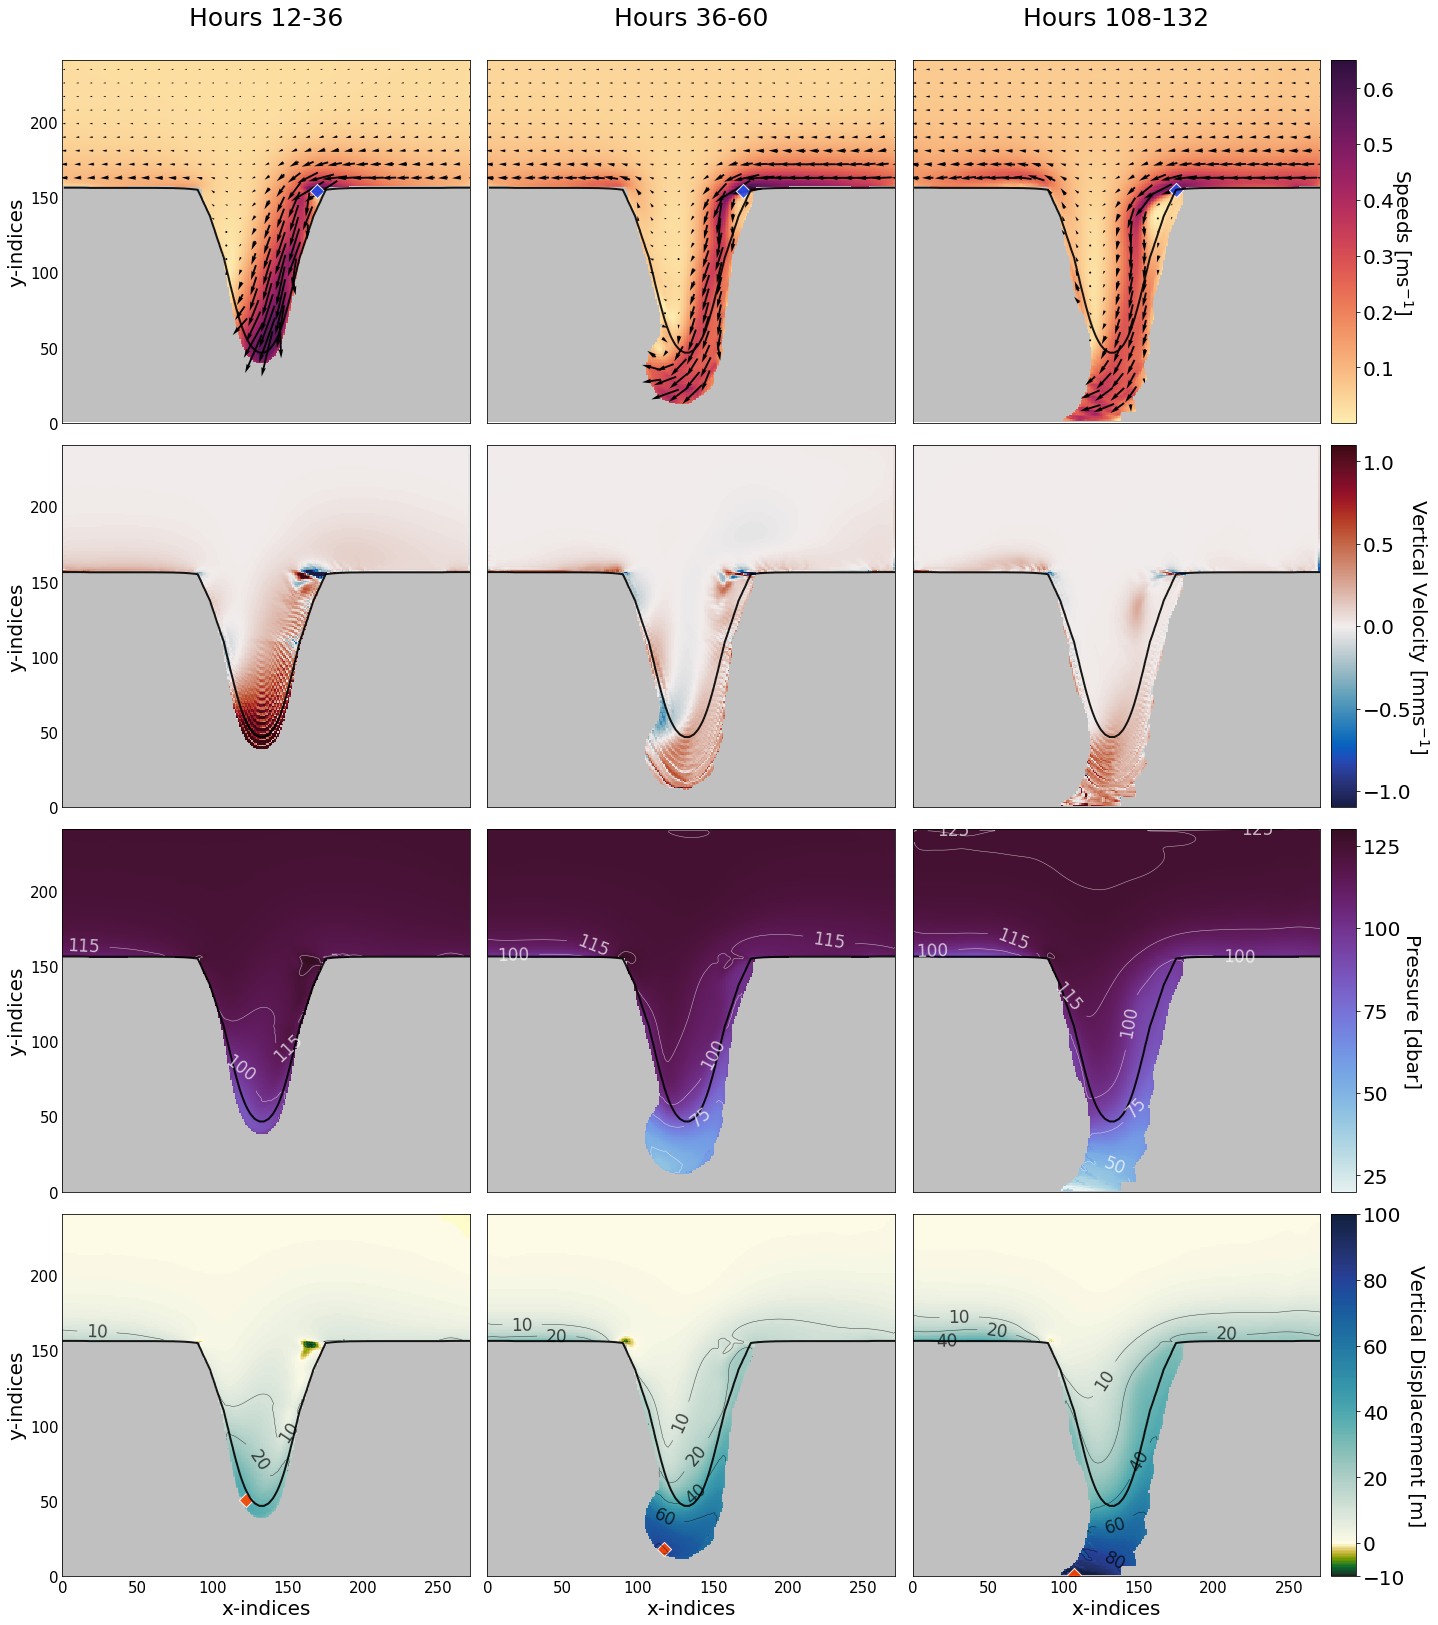

In [11]:
salt = salt_UHW_SA
vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3 = vm0_UHW, vm1_UHW, vm2_UHW, vm3_UHW, tk0_UHW, tk1_UHW, tk2_UHW, tk3_UHW
fig = plot(vosaline_daily_all, votemper_daily_all, sossheig_daily_all, vozocrtx_daily_all, vomecrty_daily_all, vovecrtz_daily_all, salt, ttls, vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3)
fig.savefig('./watermass_panels_UHW_ideal.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

----------
### ATW

Hours 12-36 0 469.71
0.01 0.2
Hours 12-36 1 469.71
-0.6 2.8
Hours 12-36 2 469.71
423.07 477.77
Hours 12-36 3 469.71
0.17 54.39
Hours 36-60 0 469.71
0.0 0.21
Hours 36-60 1 469.71
-1.3 3.12
Hours 36-60 2 469.71
379.1 483.92
Hours 36-60 3 469.71
-5.71 98.22
Hours 108-132 0 469.71
0.01 0.08
Hours 108-132 1 469.71
-0.44 3.4
Hours 108-132 2 469.71
363.12 480.59
Hours 108-132 3 469.71
-2.01 114.47


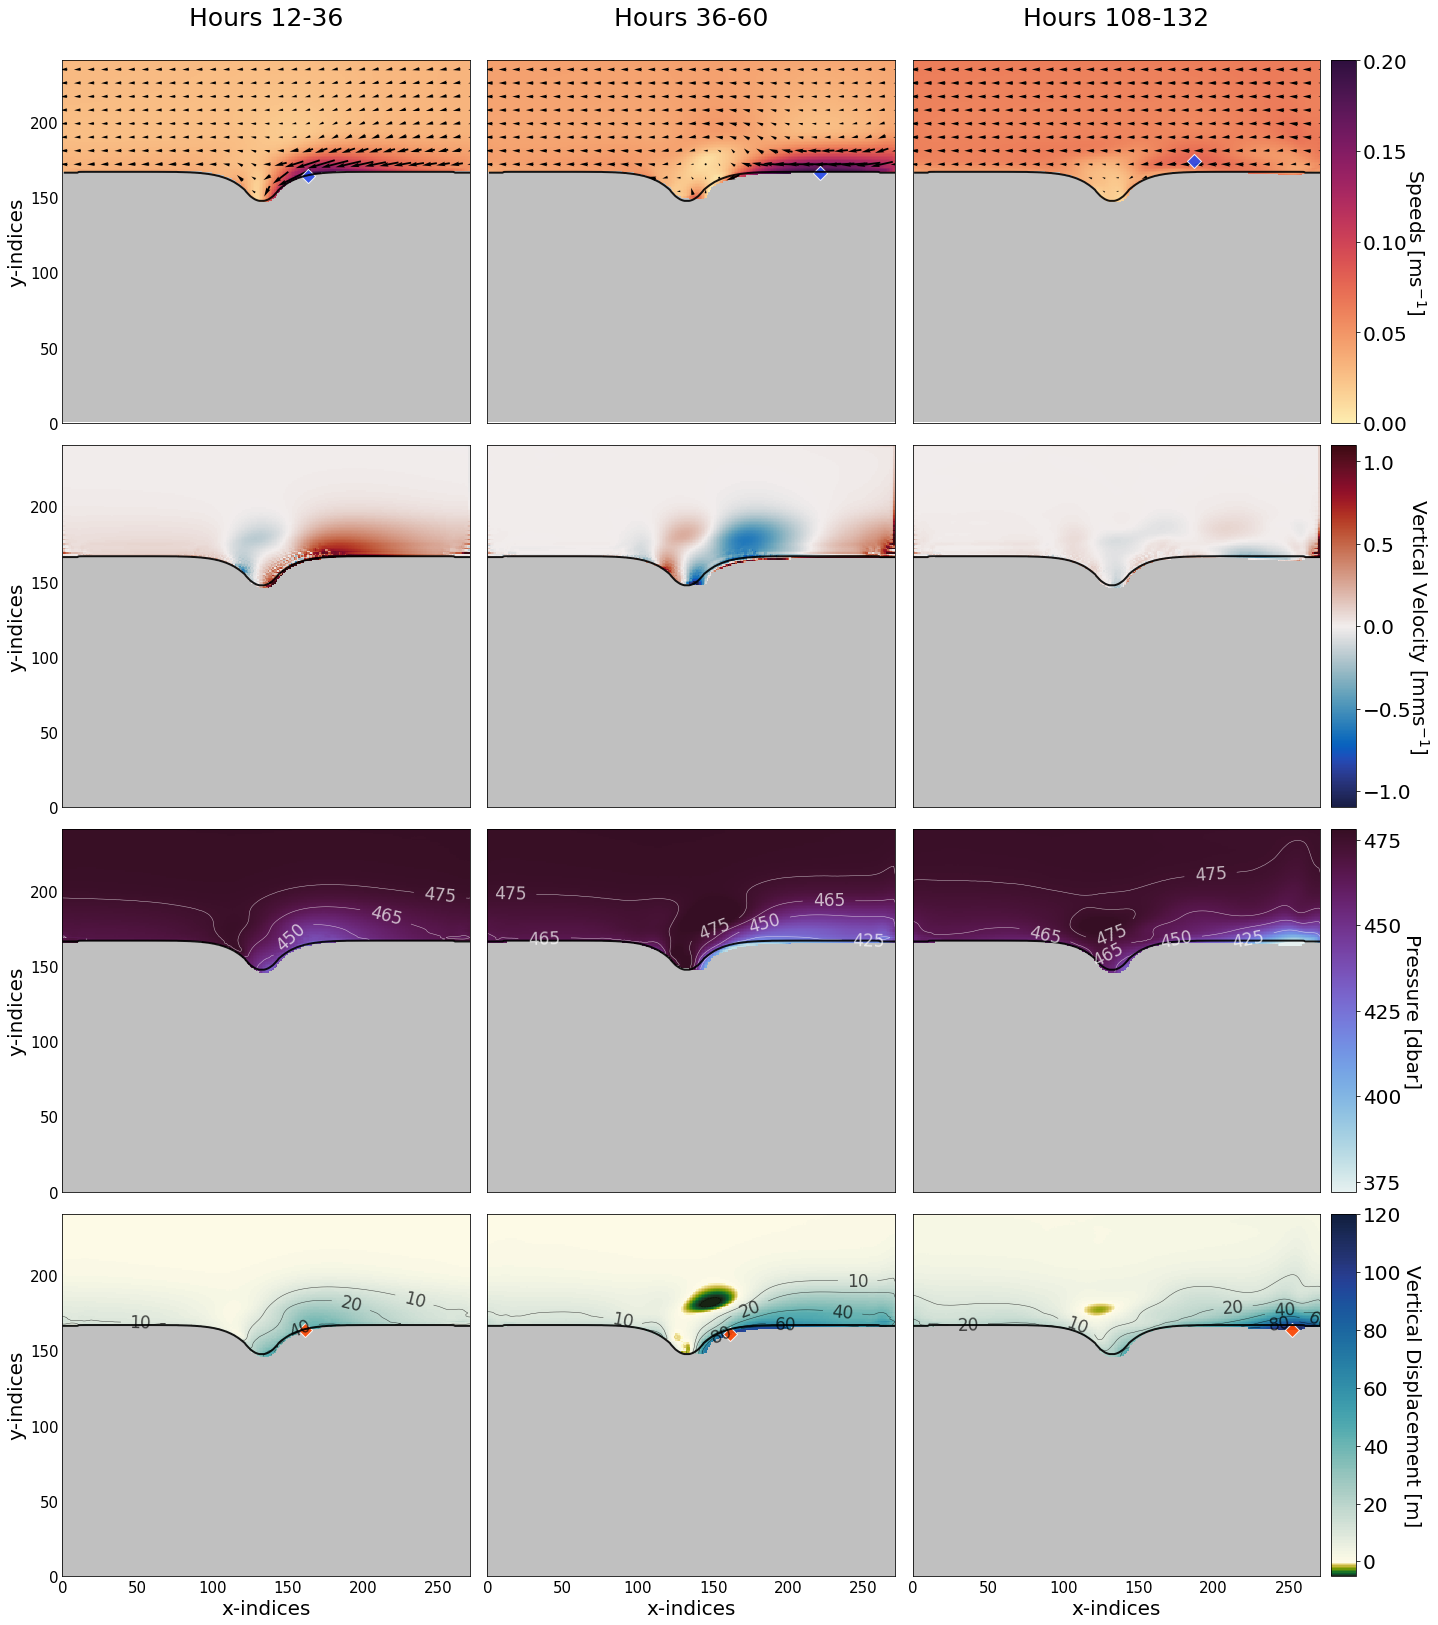

In [12]:
salt = salt_ATW_SA
vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3 = vm0_ATW, vm1_ATW, vm2_ATW, vm3_ATW, tk0_ATW, tk1_ATW, tk2_ATW, tk3_ATW
fig = plot(vosaline_daily_all, votemper_daily_all, sossheig_daily_all, vozocrtx_daily_all, vomecrty_daily_all, vovecrtz_daily_all, salt, ttls, vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3)
fig.savefig('./watermass_panels_ATW_ideal.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

# Real

In [13]:
kind = 'real'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy0 = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/1_real_bathy_for_agrif_fix.nc')['Bathymetry'][:]
bathy = bathy0[1:-1, 1:-1]

In [14]:
vosaline_daily1, votemper_daily1, sossheig_daily1, vozocrtx_daily1, vomecrty_daily1, vovecrtz_daily1, depthu, deptht, e3t = get_salt_daily(time_s_day1)
vosaline_daily2, votemper_daily2, sossheig_daily2, vozocrtx_daily2, vomecrty_daily2, vovecrtz_daily2, depthu, deptht, e3t = get_salt_daily(time_s_day2)
vosaline_daily5, votemper_daily5, sossheig_daily5, vozocrtx_daily5, vomecrty_daily5, vovecrtz_daily5, depthu, deptht, e3t = get_salt_daily(time_s_day5)

files
files
files


In [15]:
vosaline_daily_all = [vosaline_daily1, vosaline_daily2, vosaline_daily5]
vozocrtx_daily_all = [vozocrtx_daily1, vozocrtx_daily2, vozocrtx_daily5]
vomecrty_daily_all = [vomecrty_daily1, vomecrty_daily2, vomecrty_daily5]
vovecrtz_daily_all = [vovecrtz_daily1, vovecrtz_daily2, vovecrtz_daily5]
votemper_daily_all = [votemper_daily1, votemper_daily2, votemper_daily5]
sossheig_daily_all = [sossheig_daily1, sossheig_daily2, sossheig_daily5]

----------
### UHW

Hours 12-36 0 119.44
0.01 0.51
Hours 12-36 1 119.44
-2.07 2.46
Hours 12-36 2 119.44
82.35 128.1
Hours 12-36 3 119.44
-3.32 42.13
Hours 36-60 0 119.44
0.01 0.52
Hours 36-60 1 119.44
-3.23 2.03
Hours 36-60 2 119.44
43.87 124.99
Hours 36-60 3 119.44
0.08 80.56
Hours 108-132 0 119.44
0.0 0.42
Hours 108-132 1 119.44
-1.49 1.73
Hours 108-132 2 119.44
61.61 125.3
Hours 108-132 3 119.44
0.2 63.37


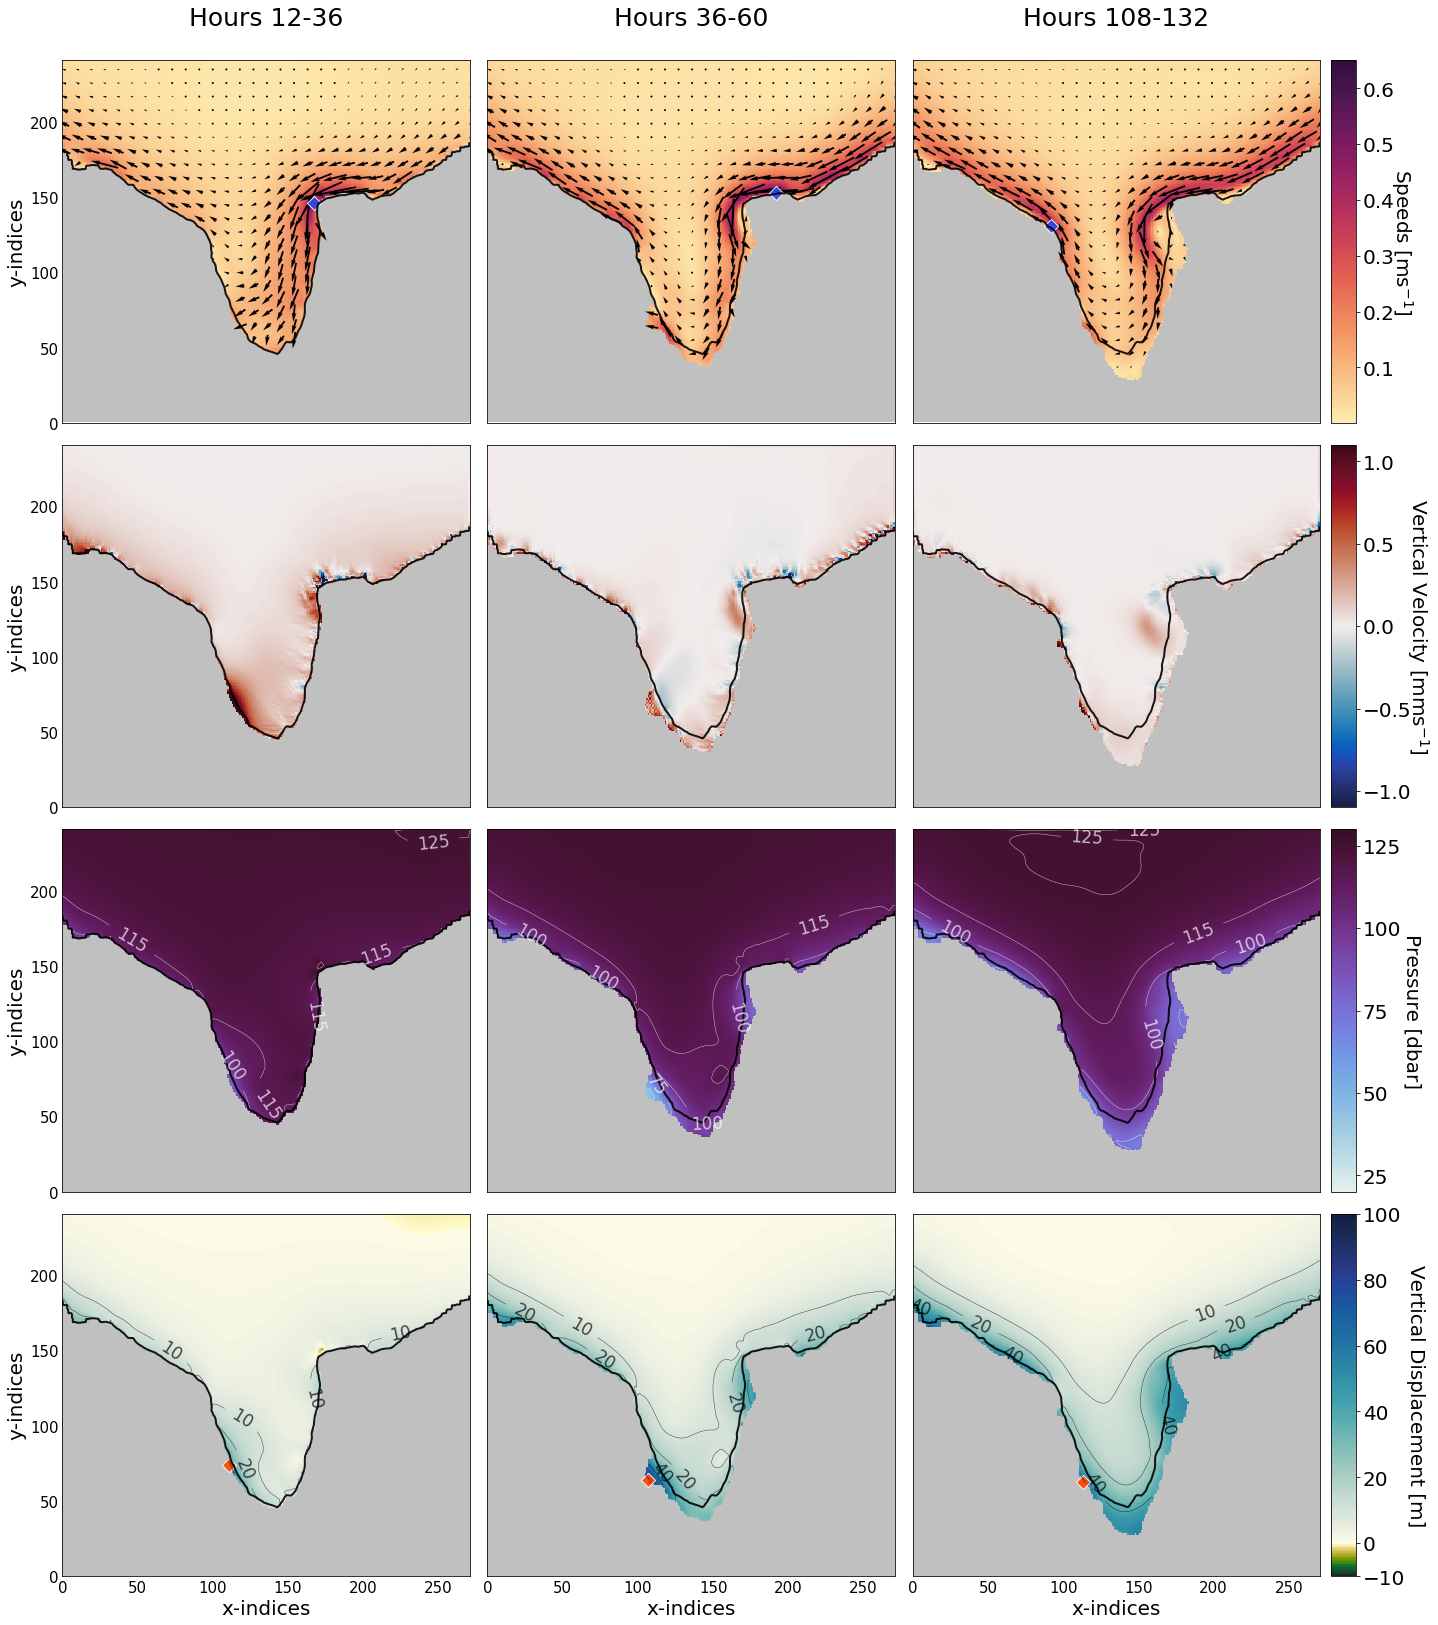

In [16]:
salt = salt_UHW_SA
vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3 = vm0_UHW, vm1_UHW, vm2_UHW, vm3_UHW, tk0_UHW, tk1_UHW, tk2_UHW, tk3_UHW
fig = plot(vosaline_daily_all, votemper_daily_all, sossheig_daily_all, vozocrtx_daily_all, vomecrty_daily_all, vovecrtz_daily_all, salt, ttls, vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3)
fig.savefig('./watermass_panels_UHW_real.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

----------
### ATW

Hours 12-36 0 469.71
0.0 0.19
Hours 12-36 1 469.71
-2.82 6.28
Hours 12-36 2 469.71
387.78 491.43
Hours 12-36 3 469.71
-13.37 89.42
Hours 36-60 0 469.71
0.0 0.21
Hours 36-60 1 469.71
-5.12 11.18
Hours 36-60 2 469.71
304.03 517.55
Hours 36-60 3 469.71
-38.92 172.72
Hours 108-132 0 469.71
0.01 0.11
Hours 108-132 1 469.71
-3.73 4.42
Hours 108-132 2 469.71
309.66 485.94
Hours 108-132 3 469.71
-7.23 167.57


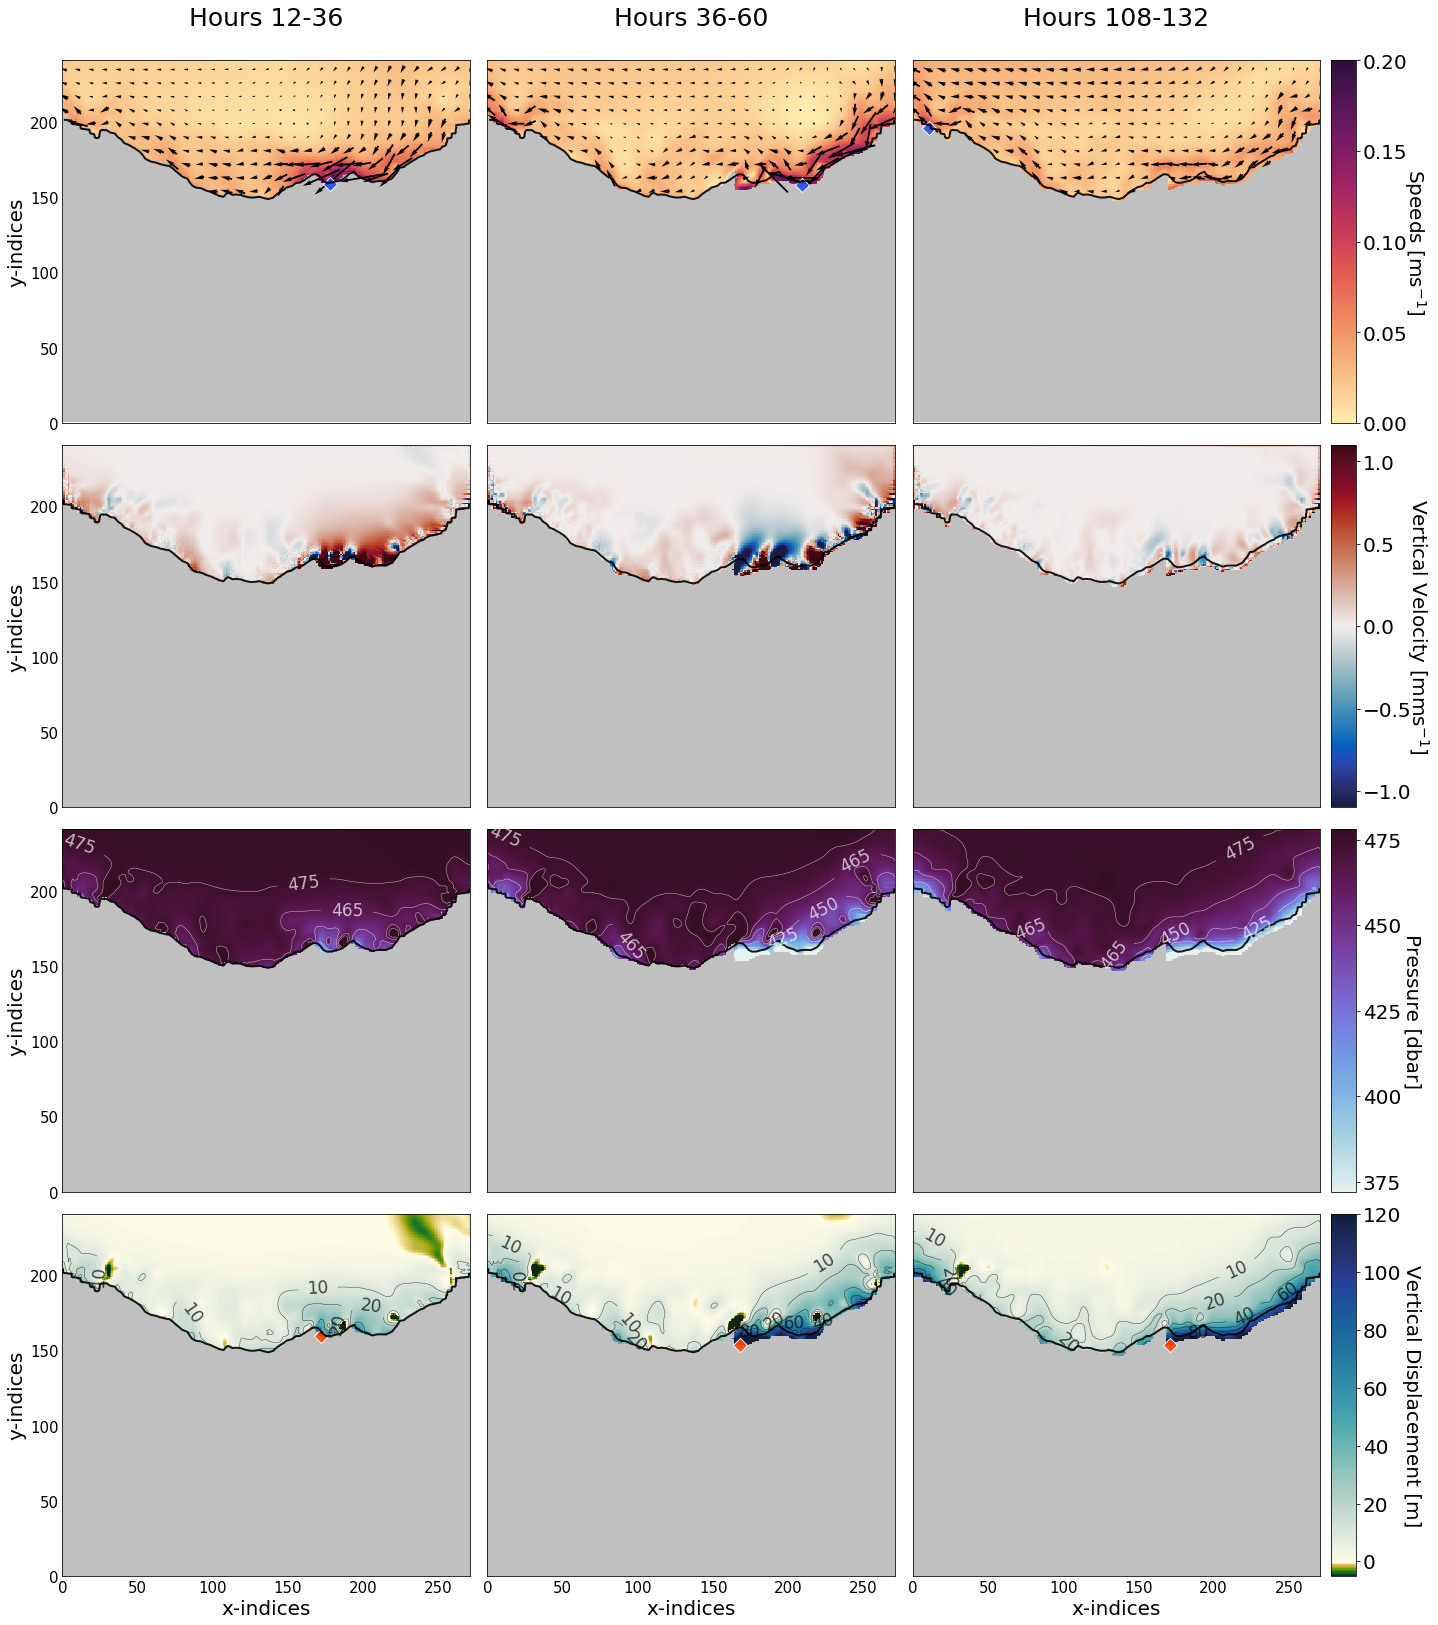

In [17]:
salt = salt_ATW_SA
vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3 = vm0_ATW, vm1_ATW, vm2_ATW, vm3_ATW, tk0_ATW, tk1_ATW, tk2_ATW, tk3_ATW
fig = plot(vosaline_daily_all, votemper_daily_all, sossheig_daily_all, vozocrtx_daily_all, vomecrty_daily_all, vovecrtz_daily_all, salt, ttls, vm0, vm1, vm2, vm3, tk0, tk1, tk2, tk3)
fig.savefig('./watermass_panels_ATW_real.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())